# CNS spring-block simulations

In this tutorial, we'll run a series of spring-block (1D fault) simulations with the _Chen-Niemeijer-Spiers_ (CNS) microphysical model. We start by importing the necessary libraries:

In [2]:
# Make plots interactive in the notebook
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

# Import QDYN wrapper
from qdyn import qdyn

/opt/cray/pe/python/3.9.13.1/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


The simulation parameters are accessible after instantiation of the QDYN class as a Python dictionary object. We first define a number of global simulation parameters:

In [3]:
# Instantiate the QDYN class object
p = qdyn()

# Get the settings dict
set_dict = p.set_dict

# Global simulation parameters
set_dict["MESHDIM"] = 0        # Simulation dimensionality (spring-block)
set_dict["TMAX"] = 200         # Maximum simulation time [s]
set_dict["NTOUT_OT"] = 1       # Save output every time step
set_dict["V_PL"] = 1e-5        # Load-point velocity [m/s]
set_dict["MU"] = 2e9           # Shear modulus [Pa]
set_dict["VS"] = 0             # Turn of radiation damping
set_dict["SIGMA"] = 5e6        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# To switch from rate-and-state friction ("RSF"; default) to the CNS model,
# we set the "FRICTION_MODEL" to "CNS"
set_dict["FRICTION_MODEL"] = "CNS"

We then overwrite the default values of specific rheological parameters:

In [4]:
set_dict["SET_DICT_CNS"]["H"] = 0.5        # Dilatancy coefficient (higher = more dilatancy)
set_dict["SET_DICT_CNS"]["PHI_C"] = 0.3    # Critical state (maximum) porosity
set_dict["SET_DICT_CNS"]["A"] = [1e-10]    # Kinetic parameter of the creep mechanism
set_dict["SET_DICT_CNS"]["N"] = [1]        # Stress exponent of the creep mechanism

# Thickness of the (localised) gouge layer [m]
set_dict["SET_DICT_CNS"]["THICKNESS"] = 1e-4
# Initial shear stress [Pa]
set_dict["SET_DICT_CNS"]["TAU"] = 0.5 * set_dict["SIGMA"]
# Initial porosity [-]
set_dict["SET_DICT_CNS"]["PHI_INI"] = 0.25

Lastly, we pass the settings to the QDYN wrapper, generate the mesh (only 1 element) and write the `qdyn.in` input file:

In [5]:
p.settings(set_dict)
p.render_mesh()
p.write_input()

True

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

In [6]:
p.run()

True

The simulation output is read and processed by the wrapper using:

In [7]:
p.read_output()

True

The simulation time series output is then stored as a pandas `DataFrame` in `p.ot`. To inspect the first 10 entries:

In [8]:
p.ot[0].head(10)

,step,t,potcy,pot_rate,v,theta,tau,dtau_dt,slip,sigma,fault_label
0,0,0.000000,0.000000e+00,9.002004e-07,9.002004e-07,0.250000,2500000.0,0.0,0.000000e+00,5000000.0,1
1,1,0.106555,9.451297e-08,8.741237e-07,8.741237e-07,0.249240,2501942.0,0.0,9.451297e-08,5000000.0,1
2,2,0.639333,5.307253e-07,7.696154e-07,7.696154e-07,0.245799,2511725.0,0.0,5.307253e-07,5000000.0,1
3,3,1.859245,1.370777e-06,6.225611e-07,6.225611e-07,0.239466,2534443.0,0.0,1.370777e-06,5000000.0,1
4,4,3.381289,2.232777e-06,5.194233e-07,5.194233e-07,0.233354,2563160.0,0.0,2.232777e-06,5000000.0,1
5,5,5.547678,3.257823e-06,4.347603e-07,4.347603e-07,0.226569,2604438.0,0.0,3.257823e-06,5000000.0,1
6,6,8.517859,4.441287e-06,3.682931e-07,3.682931e-07,0.219345,2661475.0,0.0,4.441287e-06,5000000.0,1
7,7,12.632917,5.838618e-06,3.158059e-07,3.158059e-07,0.211592,2740981.0,0.0,5.838618e-06,5000000.0,1
8,8,18.325437,7.509865e-06,2.755932e-07,2.755932e-07,0.203319,2851489.0,0.0,7.509865e-06,5000000.0,1
9,9,26.188077,9.578235e-06,2.612191e-07,2.612191e-07,0.194579,3004605.0,0.0,9.578235e-06,5000000.0,1


To see the behaviour of our spring-block fault, we can plot the time series of (normalised) shear stress, porosity, and slip velocity:

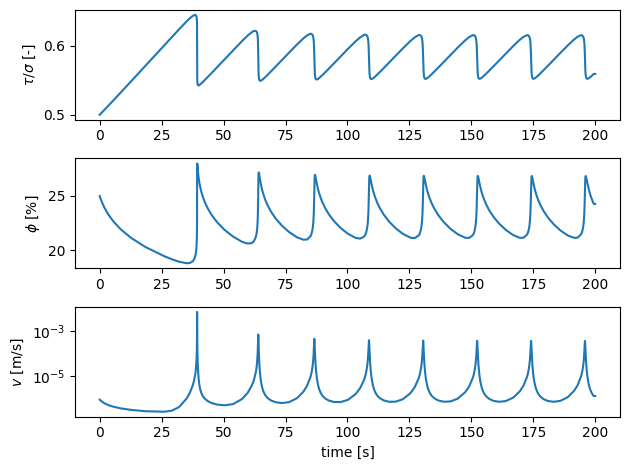

In [9]:
plt.figure()

# Normalised shear stress
plt.subplot(311)
plt.plot(p.ot[0]["t"], p.ot[0]["tau"] / set_dict["SIGMA"])
plt.ylabel(r"$\tau / \sigma$ [-]")

# Porosity
plt.subplot(312)
plt.plot(p.ot[0]["t"], 100 * p.ot[0]["theta"])
plt.ylabel(r"$\phi$ [%]")

# Velocity
plt.subplot(313)
plt.plot(p.ot[0]["t"], p.ot[0]["v"])
plt.yscale("log")
plt.ylabel(r"$v$ [m/s]")
plt.xlabel("time [s]")

plt.tight_layout()
plt.show()

Note that the stick-slip cycles converge to a stable limit cycle, even in the absence of radiation damping. This is in contrast to classical rate-and-state friction, which does not exhibit stable limit cycles.

The stability of a fault governed by CNS rheology is very sensitive to the granular flow parameters, such as the dilatancy parameter $H$ (see _van den Ende et al._ , [2018](https://doi.org/10.1016/j.tecto.2017.11.040)). By changing this value from 0.5 to 0.3, the fault stabilises at only deforms at steady-state:

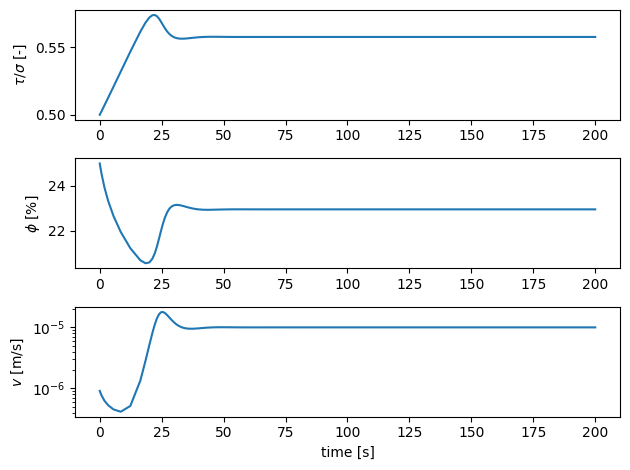

In [10]:
set_dict["SET_DICT_CNS"]["H"] = 0.3        # Updated dilatancy coefficient

# Write settings, run simulation
p.settings(set_dict)
p.render_mesh()
p.write_input()
p.run()
p.read_output()

# Plot time series
plt.figure()
plt.subplot(311)
plt.plot(p.ot[0]["t"], p.ot[0]["tau"] / set_dict["SIGMA"])
plt.ylabel(r"$\tau / \sigma$ [-]")

plt.subplot(312)
plt.plot(p.ot[0]["t"], 100 * p.ot[0]["theta"])
plt.ylabel(r"$\phi$ [%]")

plt.subplot(313)
plt.plot(p.ot[0]["t"], p.ot[0]["v"])
plt.yscale("log")
plt.ylabel(r"$v$ [m/s]")
plt.xlabel("time [s]")

plt.tight_layout()
plt.show()